In [1]:
!pip install datasets
!pip install evaluate
!pip install transformers
!pip install accelerate -U

     ---------------------------------------- 0.0/315.1 kB ? eta -:--:--
     ---- -------------------------------- 41.0/315.1 kB 653.6 kB/s eta 0:00:01
     ------------- ------------------------ 112.6/315.1 kB 1.1 MB/s eta 0:00:01
     -------------- --------------------- 122.9/315.1 kB 798.9 kB/s eta 0:00:01
     ---------------- ------------------- 143.4/315.1 kB 847.9 kB/s eta 0:00:01
     ------------------- ---------------- 174.1/315.1 kB 748.1 kB/s eta 0:00:01
     ---------------------- ------------- 194.6/315.1 kB 784.3 kB/s eta 0:00:01
     ------------------------- ---------- 225.3/315.1 kB 687.0 kB/s eta 0:00:01
     ----------------------------- ------ 256.0/315.1 kB 682.7 kB/s eta 0:00:01
     -------------------------------- --- 286.7/315.1 kB 679.3 kB/s eta 0:00:01
     ------------------------------------ 315.1/315.1 kB 673.0 kB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.32.1
    Uninstalling accelerate-0.32.1:
     

In [2]:
import requests
import torch
from PIL import Image
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments
from tqdm import tqdm

device = "cpu"

In [3]:
model_name = "google/vit-base-patch16-224"                        # the model name
image_processor = ViTImageProcessor.from_pretrained(model_name)   # load the image processor
model = ViTForImageClassification.from_pretrained(model_name)     # loading the pre-trained model

## Loading Dataset

In [4]:
from datasets import load_dataset

ds = load_dataset("albertvillanova/medmnist-v2", "retinamnist", trust_remote_code=True)    # download & load the dataset

In [5]:
labels = ds["train"].features["label"]
labels

ClassLabel(names=['0', '1', '2', '3', '4'], id=None)

## Data Preprocessing

In [6]:
def transform(examples):
  # convert all images to RGB format, then preprocessing it using our image processor
  inputs = image_processor([img.convert("RGB") for img in examples["image"]], return_tensors="pt")

  # we also shouldn't forget about the labels
  inputs["labels"] = examples["label"]

  return inputs

# use the with_transform() method to apply the transform to the dataset on the fly during training
dataset = ds.with_transform(transform)

In [7]:
import matplotlib.pyplot as plt
def show_image(dataset, split, index):
    data = dataset[split][index]
    if "image" in data:  # Original dataset
        image = data["image"]
        label = data["label"]

        plt.figure(figsize=(1, 1))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Class {label}", fontsize=8)
        plt.show()
    else:  # Transformed dataset
        image_tensor = data['pixel_values']
        label = data['labels']

        # Convert the tensor to a NumPy array and display the image
        image_array = image_tensor.numpy()  # Convert the torch tensor to a NumPy array
        plt.figure(figsize=(1, 1))
        plt.imshow(image_array.transpose(1, 2, 0))  # Matplotlib expects the channel dimension last
        plt.title(f"Class {label}", fontsize=8)
        plt.axis('off')  # Hide the axis
        plt.show()

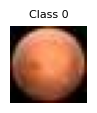

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


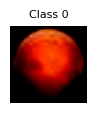

In [8]:
idx = 2
show_image(ds, "train", idx)
show_image(dataset, "train", idx)

In [9]:
for item in dataset["train"]:
  print(item["pixel_values"].shape)
  print(item["labels"])
  break

torch.Size([3, 224, 224])
0


In [10]:
labels = ds["train"].features["label"].names

def collate_fn(batch):
  return {
      "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
      "labels": torch.tensor([x["labels"] for x in batch]),
  }

In [11]:
from evaluate import load
import numpy as np

# load the accuracy and f1 metrics from the evaluate module
accuracy = load("accuracy")
f1 = load("f1")

def compute_metrics(eval_pred):
  # compute the accuracy and f1 scores & return them
  accuracy_score = accuracy.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids)
  f1_score = f1.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids, average="macro")
  return {**accuracy_score, **f1_score}

In [12]:
# load the ViT model
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.42.3', '0.33.0')

In [14]:
# defining the training arguments
training_args = TrainingArguments(
  output_dir="./vit-base-retina", # output directory
  # output_dir="./vit-base-skin-cancer",
  per_device_train_batch_size=32, # batch size per device during training
  evaluation_strategy="steps",    # evaluation strategy to adopt during training
  num_train_epochs=10,             # total number of training epochs
  # fp16=True,                    # use mixed precision
  save_steps=34,                # number of update steps before saving checkpoint
  eval_steps=34,                # number of update steps before evaluating
  logging_steps=34,             # number of update steps before logging
  # save_steps=50,
  # eval_steps=50,
  # logging_steps=50,
  save_total_limit=2,             # limit the total amount of checkpoints on disk
  remove_unused_columns=False,    # remove unused columns from the dataset
  push_to_hub=False,              # do not push the model to the hub
  report_to='tensorboard',        # report metrics to tensorboard
  load_best_model_at_end=True,    # load the best model at the end of training
  learning_rate=5e-5              # Adjust the learning rate here
)

D:\CSE299\Flutter\Anaconda\envs\A_prediction\lib\site-packages\transformers\training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:
# Create Trainer
from transformers import Trainer

trainer = Trainer(
    model=model,                        # the instantiated 🤗 Transformers model to be trained
    args=training_args,                 # training arguments, defined above
    data_collator=collate_fn,           # the data collator that will be used for batching
    compute_metrics=compute_metrics,    # the metrics function that will be used for evaluation
    train_dataset=dataset["train"],     # training dataset
    eval_dataset=dataset["validation"], # evaluation dataset
    tokenizer=image_processor,          # the processor that will be used for preprocessing the images
)

In [16]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1
34,1.253500,1.048221,0.550000,0.369120
68,1.099900,1.086842,0.583333,0.391227
102,0.986400,1.084583,0.491667,0.338940
136,0.781200,1.147458,0.508333,0.361340
170,0.535100,1.230132,0.533333,0.410472
204,0.320100,1.391174,0.525000,0.365857
238,0.163500,1.444039,0.516667,0.381624
272,0.080500,1.603897,0.525000,0.406540
306,0.038200,1.673594,0.516667,0.388273
340,0.023000,1.714437,0.500000,0.369315


TrainOutput(global_step=340, training_loss=0.5281221705324509, metrics={'train_runtime': 5205.6336, 'train_samples_per_second': 2.075, 'train_steps_per_second': 0.065, 'total_flos': 8.369359908102144e+17, 'train_loss': 0.5281221705324509, 'epoch': 10.0})

In [17]:
trainer.evaluate(dataset["test"])

{'eval_loss': 1.1654585599899292,
 'eval_accuracy': 0.5475,
 'eval_f1': 0.3395515704764264,
 'eval_runtime': 74.9004,
 'eval_samples_per_second': 5.34,
 'eval_steps_per_second': 0.668,
 'epoch': 10.0}

## Evaluation with Confusion Matrix

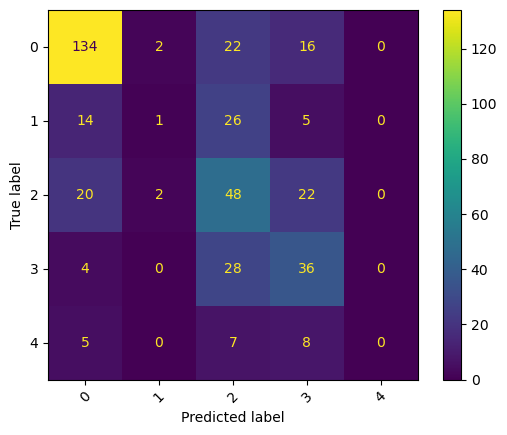

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

outputs = trainer.predict(dataset["test"])
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = dataset["train"].features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)
plt.savefig('confusion_matrix_VIT.png')

## Generate Precision, Recall, F1 Score, Support

In [19]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred, average=None)
precision, recall, f1_score, support

D:\CSE299\Flutter\Anaconda\envs\A_prediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.75706215, 0.2       , 0.36641221, 0.4137931 , 0.        ]),
 array([0.77011494, 0.02173913, 0.52173913, 0.52941176, 0.        ]),
 array([0.76353276, 0.03921569, 0.43049327, 0.46451613, 0.        ]),
 array([174,  46,  92,  68,  20], dtype=int64))

## Generate Training & Loss Curves

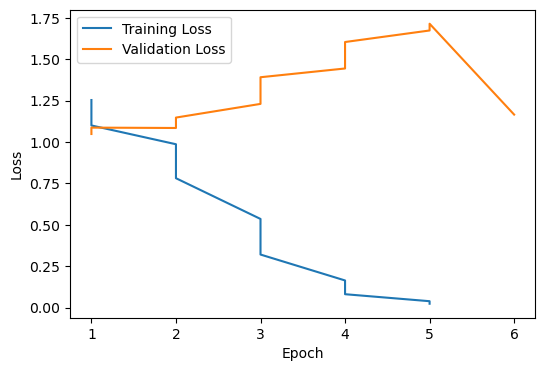

In [25]:
import matplotlib.pyplot as plt

data = trainer.state.log_history
# Extracting data for plotting
epochs = [entry['epoch'] for entry in data]  # Extract epoch values
train_losses = [entry['loss'] for entry in data if 'loss' in entry]  # Extract training losses
eval_losses = [entry['eval_loss'] for entry in data if 'eval_loss' in entry]  # Extract evaluation losses

# Plotting training and evaluation metrics
plt.figure(figsize=(6, 4))

plt.plot(epochs[:len(train_losses)], train_losses, label='Training Loss')
plt.plot(epochs[:len(eval_losses)], eval_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.title('Training and Evaluation Metrics Across Epochs')
plt.legend()
# plt.grid(True)
plt.savefig('LOSS_CURVE_VIT.png')
plt.show()

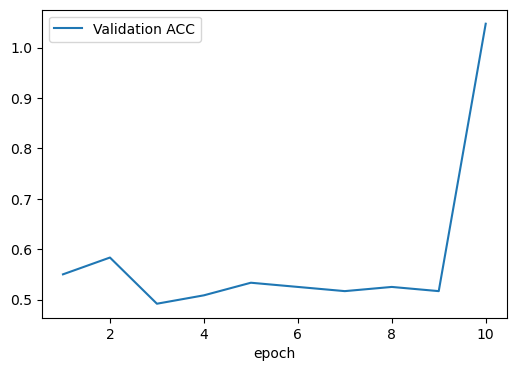

In [26]:
import pandas as pd

loghistory = pd.DataFrame(trainer.state.log_history)
loghistory = loghistory.fillna(0)
loghistory = loghistory.groupby(['epoch']).sum()
fig, ax = plt.subplots(figsize=(6, 4))  # Set the size here (width, height)
loghistory[["eval_accuracy"]].plot(subplots=True, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Validation ACC'], loc='best')
plt.savefig('Accuracy_CURVE_VIT.png')
plt.show()  # Display the plot

## Plot ROC Curves

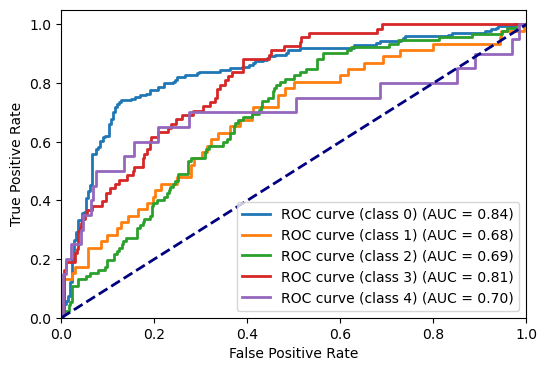

In [27]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have predictions and true labels for multi-class classification
# predictions shape: (num_samples, num_classes), where each row contains class probabilities
# true_labels shape: (num_samples,), where each value represents the true class label
true_labels = outputs.label_ids
predictions = outputs.predictions

# Compute ROC curve for each class
num_classes = predictions.shape[1]  # Number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((true_labels == i).astype(int), predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(6, 4))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (class %d) (AUC = %0.2f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('ROC_CURVE_VIT.png')
plt.show()